# House and Appartement pricing in Haute_Garonne (31)

The goal is to fecth data from data.gouv.fr of the house sell in the department 31 for finding some patterns and deploy a model to predict the value of an house or appartment.
* Source : https://files.data.gouv.fr/geo-dvf/latest/csv/  
---
The notebook is separated like that : \
1 - Necessary importation  
2 - Recuperation of all the datas (.csv) for 2023 and combined in one dataframe    
3 - Simplification and cleaning of the datas (dropped unnecessary columns, filled missing datas, convert data for ML)  
4 - Analysis for Outliers determination - Logarythmique transformation  
5 - Rapid exploratoring  
  
6 - Model : GridSearch - ElasticNet - Random Forest  
\
7 - Prediction Model


---

## Importation

In [2]:
import os
import uuid
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import scipy.stats as stats

## Data collection

### Fetch the datas, downloading and stored in one folder

In [8]:
def get_csv(url,download_folder) : 
    response = requests.get(url)
    response.raise_for_status()
    
    soup = BeautifulSoup(response.content, 'html.parser')
    
    csv_links = soup.find_all('a', href=True)
    csv_links = [link for link in csv_links if link['href'].endswith('.csv')]
    
    if not os.path.exists(download_folder):
        os.makedirs(download_folder)
              
    for link in csv_links:
        file_url = urljoin(url, link['href'])
        original_file_name = os.path.basename(link['href'])
        unique_file_name = f"{uuid.uuid4()}_{original_file_name}"
        file_path = os.path.join(download_folder, unique_file_name)
        
        try :    
            file_response = requests.get(file_url)
            file_response.raise_for_status()
    
            with open(file_path, 'wb') as file:
                file.write(file_response.content)
        except requests.exceptions.RequestException as e:
            print(f'Error downloading {unique_file_name}:{e}')
    
    print(f'Download completed for URL:{url}')   

In [10]:
# Folder location
download_folder = r'C:\Users\melan\Desktop\DeveloppementInfo\Portfolio\ProjectsData\House_Price_Toulouse\CSV'

In [12]:
# urls 
url = 'https://files.data.gouv.fr/geo-dvf/latest/csv/2023/communes/31/'

In [14]:
get_csv(url, download_folder)

Download completed for URL:https://files.data.gouv.fr/geo-dvf/latest/csv/2023/communes/31/


### Concatenation of all the data in one csv file

In [16]:
dfs = []
for file_name in os.listdir(download_folder):
    if file_name.endswith('.csv'):
        file_path = os.path.join(download_folder, file_name)
        # Lire chaque fichier CSV et l'ajouter à la liste des DataFrames
        df = pd.read_csv(file_path)
        dfs.append(df)
        
concatenated_df = pd.concat(dfs, ignore_index=True)
output_file = os.path.join(download_folder, 'concatenated.csv')
concatenated_df.to_csv(output_file, index=False)

print(f'All CSV files have been concatenated into : {output_file}')

All CSV files have been concatenated into : C:\Users\melan\Desktop\DeveloppementInfo\Portfolio\ProjectsData\House_Price_Toulouse\CSV\concatenated.csv


## Cleaning

### Reading CSV concatenated

In [18]:
df = pd.read_csv(os.path.join(download_folder, 'concatenated.csv'))

In [20]:
df.head(3)

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,...,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude
0,2023-386364,2023-01-19,1,Vente,373350.0,81.0,NaN,CHE DE VILLENEUVE,0160,31860.0,...,Maison,80.0,4.0,S,sols,NaN,NaN,730.0,1.390293,43.473174
1,2023-386364,2023-01-19,1,Vente,373350.0,NaN,NaN,VILLENEUVE,B021,31860.0,...,NaN,NaN,NaN,T,terres,NaN,NaN,42.0,1.390278,43.473327
2,2023-386364,2023-01-19,1,Vente,373350.0,NaN,NaN,VILLENEUVE,B021,31860.0,...,NaN,NaN,NaN,T,terres,NaN,NaN,370.0,1.390746,43.473093


### Cleaning the number of lines

I am only interested in houses, apartments which are sold "normally" (not at auction, or "sold as is", ...).

In [22]:
df = df[(df.type_local=="Maison")|(df.type_local=="Appartement")].reset_index()

In [24]:
df = df[df.nature_mutation=='Vente']

In [26]:
df = df.drop_duplicates(subset=['id_mutation'])

In [28]:
len(df)

18786

### Cleaning features

In [30]:
df = df[['valeur_fonciere','code_postal','type_local','surface_reelle_bati','nombre_pieces_principales','nature_culture','surface_terrain']]

In [32]:
df = df.reset_index(drop=True)

In [34]:
df

,valeur_fonciere,code_postal,type_local,surface_reelle_bati,nombre_pieces_principales,nature_culture,surface_terrain
0,373350.0,31860.0,Maison,80.0,4.0,sols,730.0
1,225000.0,31860.0,Maison,85.0,4.0,NaN,NaN
2,315000.0,31860.0,Maison,100.0,4.0,sols,1372.0
3,194750.0,31860.0,Appartement,80.0,4.0,NaN,NaN
4,206350.0,31860.0,Maison,84.0,4.0,sols,423.0
...,...,...,...,...,...,...,...
18781,29000.0,31800.0,Maison,50.0,1.0,sols,50.0
18782,30000.0,31800.0,Maison,110.0,4.0,sols,165.0
18783,115000.0,31190.0,Maison,80.0,3.0,sols,153.0
18784,289500.0,31190.0,Maison,99.0,6.0,sols,1071.0


### Code_postal

In [36]:
df['code_postal'] = df['code_postal'].apply(str)
df['code_postal'] = df['code_postal'].str.split('.').str[0]

### Missing data

In [38]:
def percent_missing(df):
    per_nan = 100*df.isnull().sum() /len(df)
    per_nan = per_nan[per_nan >0].sort_values()
    
    return per_nan

In [40]:
per_nan = percent_missing(df)
per_nan

valeur_fonciere     0.058554
nature_culture     56.355797
surface_terrain    56.355797
dtype: float64

In [42]:
df = df.dropna(subset=['valeur_fonciere'])

In [ ]:
df['nature_culture'] = df['nature_culture'].fillna('None')
df['surface_terrain'] = df['surface_terrain'].fillna(0)

In [46]:
per_nan = percent_missing(df)
per_nan

Series([], dtype: float64)

### Exterior

In [48]:
df['nature_culture'].value_counts()

nature_culture
None                   10582
sols                    7404
terrains d'agrément      421
terres                   135
jardins                   80
terrains a bâtir          73
prés                      49
landes                    18
taillis simples           10
taillis sous futaie        2
vignes                     1
Name: count, dtype: int64

In [50]:
df['exterieur'] = df['nature_culture'].apply(lambda x: 0 if x== 'None' else 1)

C:\Users\melan\AppData\Local\Temp\ipykernel_4880\2905792572.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['exterieur'] = df['nature_culture'].apply(lambda x: 0 if x== 'None' else 1)


In [54]:
df = df.drop(['nature_culture'],axis=1)

In [56]:
df

,valeur_fonciere,code_postal,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,exterieur
0,373350.0,31860,Maison,80.0,4.0,730.0,1
1,225000.0,31860,Maison,85.0,4.0,0.0,0
2,315000.0,31860,Maison,100.0,4.0,1372.0,1
3,194750.0,31860,Appartement,80.0,4.0,0.0,0
4,206350.0,31860,Maison,84.0,4.0,423.0,1
...,...,...,...,...,...,...,...
18781,29000.0,31800,Maison,50.0,1.0,50.0,1
18782,30000.0,31800,Maison,110.0,4.0,165.0,1
18783,115000.0,31190,Maison,80.0,3.0,153.0,1
18784,289500.0,31190,Maison,99.0,6.0,1071.0,1


## Save the clean data, separated House and Apartement (Appt)

In [58]:
#save version df final
df.to_csv("HouseApptPrice_Tls.csv",index=False)

In [60]:
# Separate apartment and house
df_maison = df[df['type_local']=='Maison']
df_appt = df[df['type_local']=='Appartement']

In [62]:
df_maison.to_csv("HousePrice_Tls.csv",index=False)
df_appt.to_csv("ApptPrice_Tls.csv",index=False)

In [64]:
len(df_maison)

8483

In [66]:
len(df_appt)

10292

## Analysis for outliers determination

### Analysis

In [257]:
df_house = pd.read_csv("HousePrice_Tls.csv")

In [153]:
df_house['valeur_fonciere'].describe()

count    8.483000e+03
mean     3.115645e+05
std      2.310632e+05
min      1.000000e+00
25%      1.927500e+05
50%      2.760000e+05
75%      3.754250e+05
max      6.000146e+06
Name: valeur_fonciere, dtype: float64

C:\Users\melan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


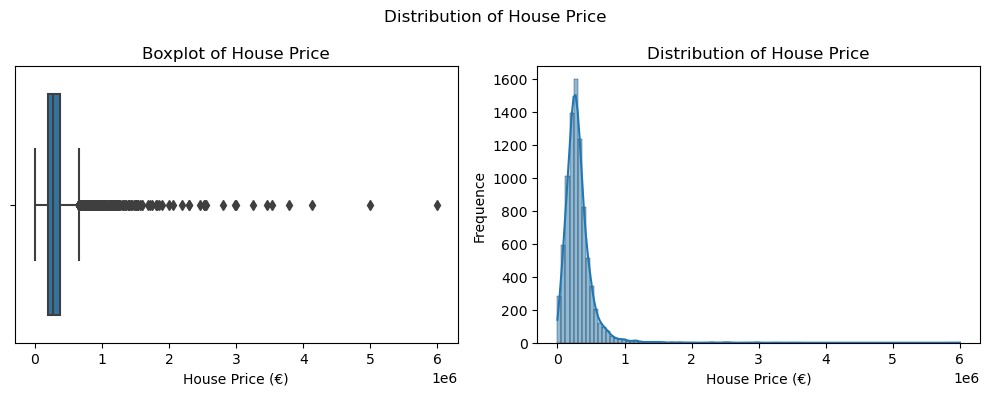

In [259]:
fig, axes = plt.subplots(1,2,figsize=(10, 4))

sns.boxplot(x=df_house['valeur_fonciere'], ax=axes[0])
axes[0].set_xlabel('House Price (€)')
axes[0].set_title('Boxplot of House Price')


sns.histplot(df_house['valeur_fonciere'], bins=100, kde=True,ax=axes[1])
axes[1].set_xlabel('House Price (€)')
axes[1].set_ylabel('Frequence')
axes[1].set_title('Distribution of House Price')


fig.suptitle('Distribution of House Price')  
plt.tight_layout()
plt.show()

### Outliers superior

In [261]:
def find_outliers(df):
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    IQR = q3-q1
    outliers=df[((df<(q1-1.5*IQR)) | (df>(q3 + 1.5*IQR)))]
    return outliers 

In [263]:
outliers_valeur_fonciere = pd.DataFrame(find_outliers(df_house['valeur_fonciere']))

In [265]:
index_outliers_valeur_fonciere = outliers_valeur_fonciere.index

In [267]:
len(index_outliers_valeur_fonciere)

399

In [269]:
df_house_cleaned = df_house.drop(index=index_outliers_valeur_fonciere)

### Outliers inf

In [275]:
count_below_20000 = len(df_house_cleaned[df_house_cleaned['valeur_fonciere'] < 20000])
print(f"Nombre de ventes inférieures à 20 000 €: {count_below_20000}")

Nombre de ventes inférieures à 20 000 €: 58


C:\Users\melan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\melan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\melan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


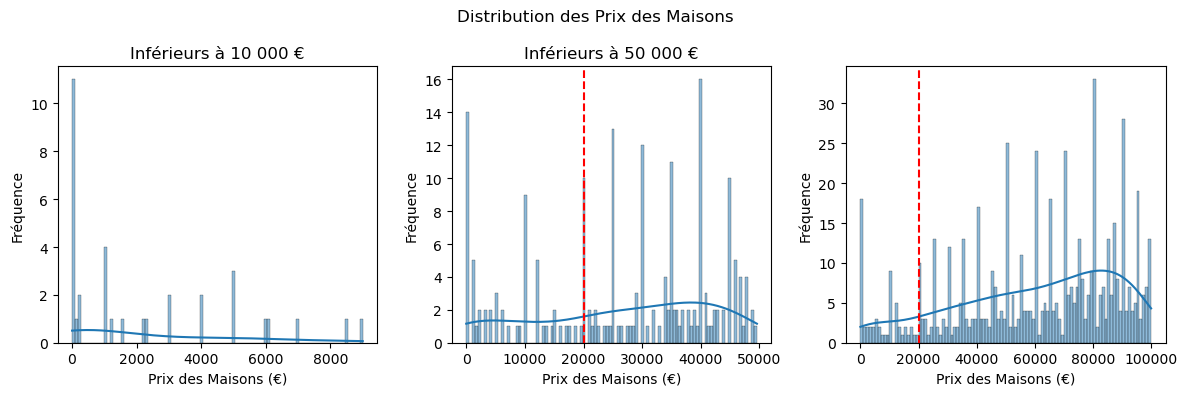

In [277]:
fig, axes = plt.subplots(1,3,figsize=(12, 4))

sns.histplot(df_house_cleaned[df_house_cleaned['valeur_fonciere'] < 10000]['valeur_fonciere'], bins=100, kde=True,ax=axes[0])
sns.histplot(df_house_cleaned[df_house_cleaned['valeur_fonciere'] < 50000]['valeur_fonciere'], bins=100, kde=True,ax=axes[1])
sns.histplot(df_house_cleaned[df_house_cleaned['valeur_fonciere'] < 100000]['valeur_fonciere'], bins=100, kde=True,ax=axes[2])

for axe in axes.flat :
    axe.set(xlabel='Prix des Maisons (€)',ylabel='Fréquence')
    axe.set_ylabel('Fréquence')

fig.suptitle('Distribution des Prix des Maisons')  

axes[0].set_title('Inférieurs à 10 000 €')
axes[1].set_title('Inférieurs à 50 000 €')
axes[1].axvline(x=20000,color='red',linestyle='--')
axes[2].axvline(x=20000,color='red',linestyle='--')

plt.tight_layout()

In [279]:
df_house_cleaned = df_house_cleaned[df_house_cleaned['valeur_fonciere'] > 20000]

C:\Users\melan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


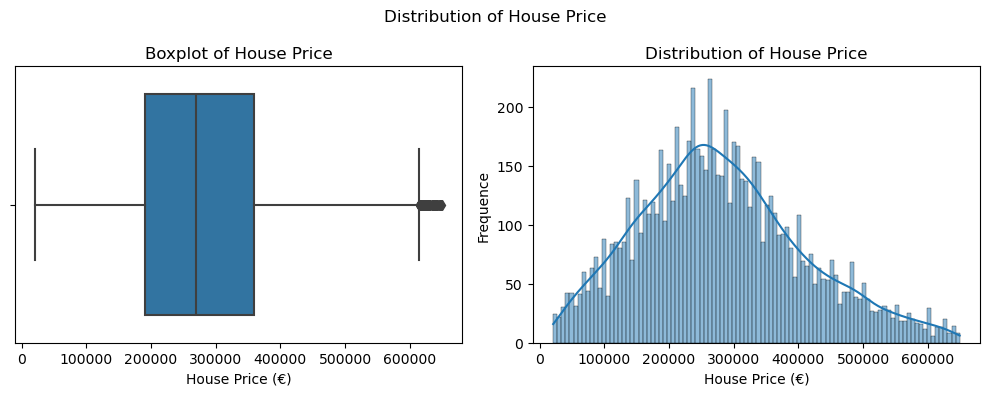

In [283]:
fig, axes = plt.subplots(1,2,figsize=(10, 4))

sns.boxplot(x=df_house_cleaned['valeur_fonciere'], ax=axes[0])
axes[0].set_xlabel('House Price (€)')
axes[0].set_title('Boxplot of House Price')


sns.histplot(df_house_cleaned['valeur_fonciere'], bins=100, kde=True,ax=axes[1])
axes[1].set_xlabel('House Price (€)')
axes[1].set_ylabel('Frequence')
axes[1].set_title('Distribution of House Price')


fig.suptitle('Distribution of House Price')  
plt.tight_layout()
plt.show()

In [285]:
df_house_cleaned['valeur_fonciere'].describe()

count      8016.000000
mean     281075.198167
std      127740.649119
min       21000.000000
25%      190000.000000
50%      270000.000000
75%      359675.000000
max      649300.000000
Name: valeur_fonciere, dtype: float64

### Outliers observed in others features

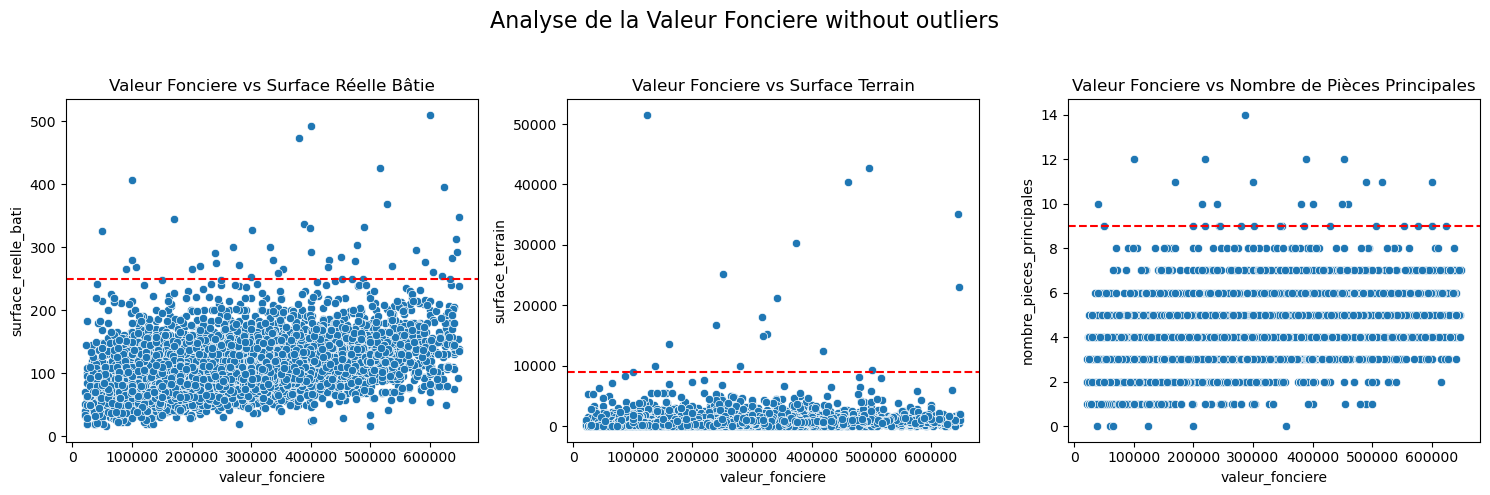

In [291]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

sns.scatterplot(data=df_house_cleaned, x='valeur_fonciere', y='surface_reelle_bati', ax=axes[0])
axes[0].set_title('Valeur Fonciere vs Surface Réelle Bâtie')
axes[0].axhline(y=250,color='red', linestyle='--')

sns.scatterplot(data=df_house_cleaned, x='valeur_fonciere', y='surface_terrain', ax=axes[1])
axes[1].set_title('Valeur Fonciere vs Surface Terrain')
axes[1].axhline(y=9000,color='red', linestyle='--')

sns.scatterplot(data=df_house_cleaned, x='valeur_fonciere', y='nombre_pieces_principales', ax=axes[2])
axes[2].set_title('Valeur Fonciere vs Nombre de Pièces Principales')
axes[2].axhline(y=9,color='red', linestyle='--')

fig.suptitle('Analyse de la Valeur Fonciere without outliers', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()

In [293]:
drop_ind_bati = df_house_cleaned[(df_house_cleaned['surface_reelle_bati']>250)].index
drop_ind_terrain = df_house_cleaned[(df_house_cleaned['surface_terrain']>9000)].index
drop_ind_piece = df_house_cleaned[(df_house_cleaned['nombre_pieces_principales']>10)].index

drop_indices = drop_ind_bati.union(drop_ind_terrain).union(drop_ind_piece)

df_house_cleaned = df_house_cleaned.drop(drop_indices,axis=0)

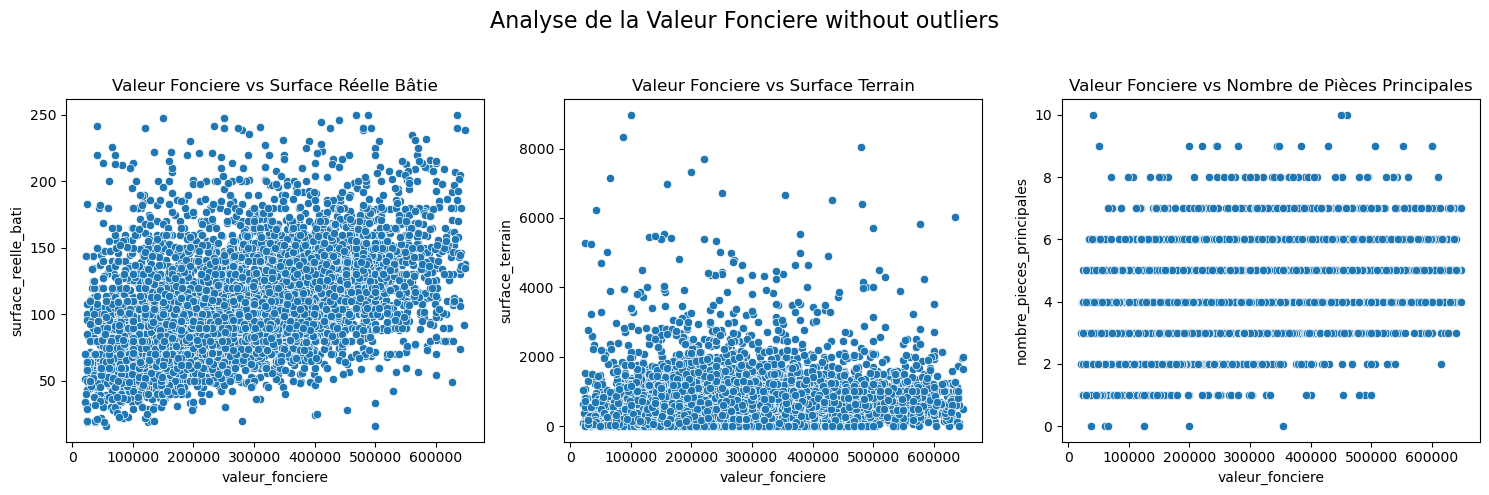

In [295]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

sns.scatterplot(data=df_house_cleaned, x='valeur_fonciere', y='surface_reelle_bati', ax=axes[0])
axes[0].set_title('Valeur Fonciere vs Surface Réelle Bâtie')


sns.scatterplot(data=df_house_cleaned, x='valeur_fonciere', y='surface_terrain', ax=axes[1])
axes[1].set_title('Valeur Fonciere vs Surface Terrain')


sns.scatterplot(data=df_house_cleaned, x='valeur_fonciere', y='nombre_pieces_principales', ax=axes[2])
axes[2].set_title('Valeur Fonciere vs Nombre de Pièces Principales')


fig.suptitle('Analyse de la Valeur Fonciere without outliers', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()

In [297]:
df_house_cleaned = df_house_cleaned.reset_index(drop=True)

### Log transformation

In [299]:
df_house_cleaned['log_valeur_fonciere'] = np.log1p(df_house_cleaned['valeur_fonciere'])

C:\Users\melan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


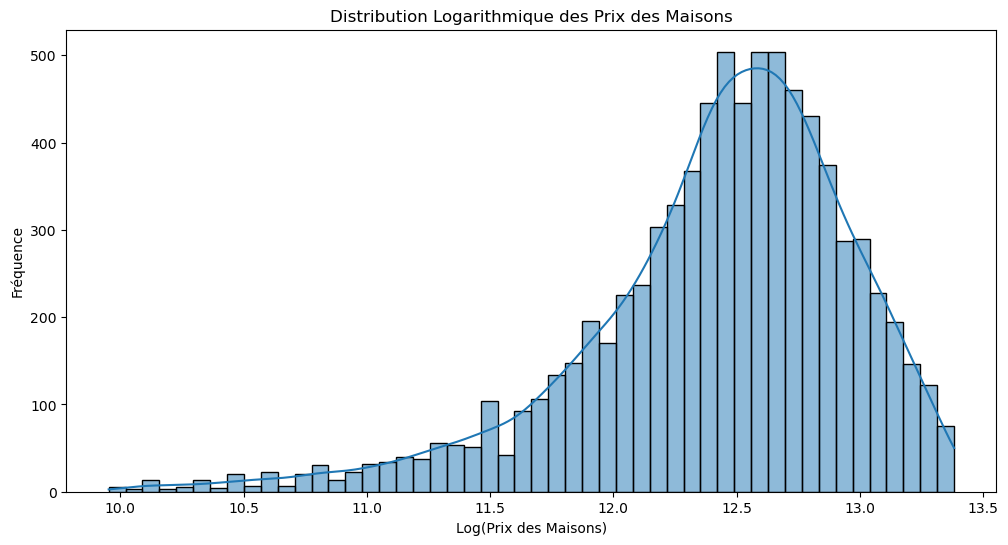

In [301]:
plt.figure(figsize=(12, 6))
sns.histplot(df_house_cleaned['log_valeur_fonciere'], bins=50, kde=True)
plt.title('Distribution Logarithmique des Prix des Maisons')
plt.xlabel('Log(Prix des Maisons)')
plt.ylabel('Fréquence')
plt.show()

In [303]:
df_house_cleaned.to_csv('HousePrice_Tls_cleaned.csv',index=False)

## EDA

In [305]:
df = pd.read_csv('HousePrice_Tls_cleaned.csv')

In [307]:
df['valeur_fonciere'].describe()

count      7954.000000
mean     280366.763956
std      127143.187461
min       21000.000000
25%      190000.000000
50%      269235.000000
75%      358080.500000
max      648300.000000
Name: valeur_fonciere, dtype: float64

In [309]:
df['log_valeur_fonciere'].describe()

count    7954.000000
mean       12.416667
std         0.553014
min         9.952325
25%        12.154785
50%        12.503344
75%        12.788516
max        13.382110
Name: log_valeur_fonciere, dtype: float64

### Correlation

In [311]:
corr = df.corr(numeric_only = True)
corr.style.background_gradient(cmap='coolwarm')

,valeur_fonciere,code_postal,surface_reelle_bati,nombre_pieces_principales,surface_terrain,exterieur,log_valeur_fonciere
valeur_fonciere,1.000000,0.027221,0.447124,0.392757,0.145472,0.082110,0.933031
code_postal,0.027221,1.000000,0.040681,0.031979,0.046785,0.007671,0.041422
surface_reelle_bati,0.447124,0.040681,1.000000,0.665969,0.290287,0.137025,0.392940
nombre_pieces_principales,0.392757,0.031979,0.665969,1.000000,0.135759,0.068439,0.384546
surface_terrain,0.145472,0.046785,0.290287,0.135759,1.000000,0.287871,0.120664
exterieur,0.082110,0.007671,0.137025,0.068439,0.287871,1.000000,0.042574
log_valeur_fonciere,0.933031,0.041422,0.392940,0.384546,0.120664,0.042574,1.000000


### Filtering by postal code

In [313]:
#ex:
df_house_31600 = df[df['code_postal'] == 31600]

In [315]:
stats.linregress(df_house_31600['valeur_fonciere'],df_house_31600['surface_reelle_bati'])

LinregressResult(slope=0.00018705192996910556, intercept=52.370673633202756, rvalue=0.5870841844948123, pvalue=7.798789539891463e-36, stderr=1.3408854898383954e-05, intercept_stderr=3.9866164862527107)

<Axes: xlabel='valeur_fonciere', ylabel='surface_reelle_bati'>

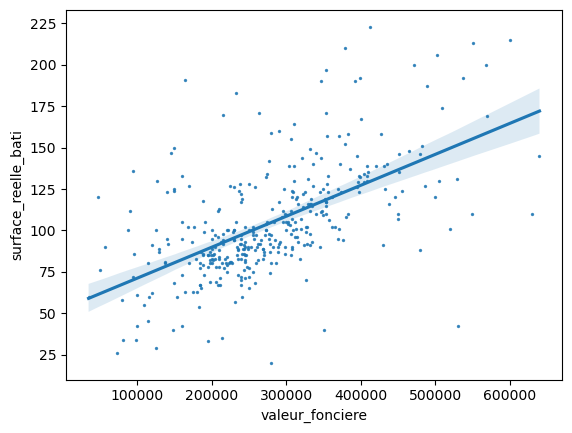

In [317]:
sns.regplot(x=df_house_31600['valeur_fonciere'], y=df_house_31600['surface_reelle_bati'],scatter_kws={'s':2})

<Axes: xlabel='log_valeur_fonciere', ylabel='surface_reelle_bati'>

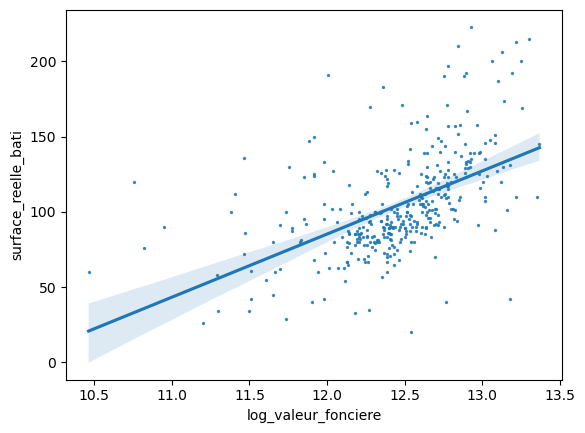

In [319]:
sns.regplot(x=df_house_31600['log_valeur_fonciere'], y=df_house_31600['surface_reelle_bati'],scatter_kws={'s':2})

In [323]:
def calculate_correlation(group):
    return group['valeur_fonciere'].corr(group['surface_reelle_bati'])

In [325]:
def calculate_correlation_log(group):
    return group['log_valeur_fonciere'].corr(group['surface_reelle_bati'])

In [327]:
correlation_by_postal_code = df.groupby('code_postal').apply(calculate_correlation)

count_above_05 = (correlation_by_postal_code > 0.5).sum()
count_above_05

46

In [329]:
correlation_by_postal_code_log = df.groupby('code_postal').apply(calculate_correlation_log)

count_log_above_05 = (correlation_by_postal_code_log > 0.5).sum()
count_log_above_05

36

## Feature Engeneering

In [335]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7954 entries, 0 to 7953
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   valeur_fonciere            7954 non-null   float64
 1   code_postal                7954 non-null   object 
 2   type_local                 7954 non-null   object 
 3   surface_reelle_bati        7954 non-null   float64
 4   nombre_pieces_principales  7954 non-null   float64
 5   surface_terrain            7954 non-null   float64
 6   exterieur                  7954 non-null   int64  
 7   log_valeur_fonciere        7954 non-null   float64
dtypes: float64(5), int64(1), object(2)
memory usage: 497.3+ KB


In [331]:
# Type colonne object (categorie):
df['code_postal'] = df['code_postal'].astype(str)

In [337]:
df = df.drop('type_local',axis=1)

In [339]:
df_value = df.drop('log_valeur_fonciere',axis=1)

In [341]:
df_log = df.drop('valeur_fonciere',axis=1)

In [343]:
df_value.to_csv('HousePrice_value.csv',index=False)
df_log.to_csv('HousePrice_Logvalue.csv',index=False)

#### dummies

In [345]:
df_ml = pd.read_csv('HousePrice_Logvalue.csv')
df_ml

,code_postal,surface_reelle_bati,nombre_pieces_principales,surface_terrain,exterieur,log_valeur_fonciere
0,31860,80.0,4.0,730.0,1,12.830274
1,31860,85.0,4.0,0.0,0,12.323860
2,31860,100.0,4.0,1372.0,1,12.660331
3,31860,84.0,4.0,423.0,1,12.237334
4,31430,200.0,2.0,2100.0,1,12.778086
...,...,...,...,...,...,...
7949,31800,50.0,1.0,50.0,1,10.275086
7950,31800,110.0,4.0,165.0,1,10.308986
7951,31190,80.0,3.0,153.0,1,11.652696
7952,31190,99.0,6.0,1071.0,1,12.575914


In [347]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7954 entries, 0 to 7953
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   code_postal                7954 non-null   int64  
 1   surface_reelle_bati        7954 non-null   float64
 2   nombre_pieces_principales  7954 non-null   float64
 3   surface_terrain            7954 non-null   float64
 4   exterieur                  7954 non-null   int64  
 5   log_valeur_fonciere        7954 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 373.0 KB


In [349]:
df_ml['code_postal'] = df_ml['code_postal'].astype(str)
df_ml['exterieur'] = df_ml['exterieur'].astype(str)

In [351]:
my_object_df = df_ml[['code_postal','exterieur']]

In [353]:
my_numeric_df = df_ml[['log_valeur_fonciere','surface_reelle_bati','nombre_pieces_principales','surface_terrain']]

In [355]:
df_objects_dummies = pd.get_dummies(my_object_df,drop_first=True)

In [357]:
df_objects_dummies

,code_postal_31100,code_postal_31110,code_postal_31120,code_postal_31130,code_postal_31140,code_postal_31150,code_postal_31160,code_postal_31170,code_postal_31180,code_postal_31190,...,code_postal_31800,code_postal_31810,code_postal_31820,code_postal_31830,code_postal_31840,code_postal_31850,code_postal_31860,code_postal_31870,code_postal_31880,exterieur_1
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7949,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,True
7950,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,True
7951,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
7952,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True


In [359]:
final_df= pd.concat([my_numeric_df,df_objects_dummies],axis=1)

In [361]:
final_df

,log_valeur_fonciere,surface_reelle_bati,nombre_pieces_principales,surface_terrain,code_postal_31100,code_postal_31110,code_postal_31120,code_postal_31130,code_postal_31140,code_postal_31150,...,code_postal_31800,code_postal_31810,code_postal_31820,code_postal_31830,code_postal_31840,code_postal_31850,code_postal_31860,code_postal_31870,code_postal_31880,exterieur_1
0,12.830274,80.0,4.0,730.0,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True
1,12.323860,85.0,4.0,0.0,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,12.660331,100.0,4.0,1372.0,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True
3,12.237334,84.0,4.0,423.0,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True
4,12.778086,200.0,2.0,2100.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7949,10.275086,50.0,1.0,50.0,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,True
7950,10.308986,110.0,4.0,165.0,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,True
7951,11.652696,80.0,3.0,153.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
7952,12.575914,99.0,6.0,1071.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [363]:
final_df.to_csv('HousePricefinal_ML.csv',index=False)

## modele regression lineaire (ElastiqueNet puis Lasso ou autre...)

In [365]:
df = pd.read_csv('HousePricefinal_ML.csv')

In [367]:
df

,log_valeur_fonciere,surface_reelle_bati,nombre_pieces_principales,surface_terrain,code_postal_31100,code_postal_31110,code_postal_31120,code_postal_31130,code_postal_31140,code_postal_31150,...,code_postal_31800,code_postal_31810,code_postal_31820,code_postal_31830,code_postal_31840,code_postal_31850,code_postal_31860,code_postal_31870,code_postal_31880,exterieur_1
0,12.830274,80.0,4.0,730.0,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True
1,12.323860,85.0,4.0,0.0,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,12.660331,100.0,4.0,1372.0,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True
3,12.237334,84.0,4.0,423.0,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True
4,12.778086,200.0,2.0,2100.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7949,10.275086,50.0,1.0,50.0,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,True
7950,10.308986,110.0,4.0,165.0,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,True
7951,11.652696,80.0,3.0,153.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
7952,12.575914,99.0,6.0,1071.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


### Creation X et y

In [369]:
X= df.drop('log_valeur_fonciere',axis=1)
y=df['log_valeur_fonciere']

### Train Test split

In [371]:
from sklearn.model_selection import train_test_split

In [373]:
#Test 10%,  random : 101
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

### Mise a l'echelle

In [375]:
from sklearn.preprocessing import StandardScaler

In [377]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Modele RL : ElasticNet

In [379]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

In [381]:
model = ElasticNet(max_iter=100000)

In [383]:
param_grid = {'alpha':[0.1,1.5,10,50,100],'l1_ratio':[0.1,0.5,0.7,0.9,0.95,0.99,1]}

In [385]:
grid_model = GridSearchCV(estimator=model,param_grid=param_grid,scoring='neg_mean_squared_error',cv=5,verbose=1)

In [387]:
grid_model.fit(X_train,y_train)

Fitting 5 folds for each of 35 candidates, totalling 175 fits


GridSearchCV(cv=5, estimator=ElasticNet(max_iter=100000),
             param_grid={'alpha': [0.1, 1.5, 10, 50, 100],
                         'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]},
             scoring='neg_mean_squared_error', verbose=1)

In [389]:
grid_model.best_estimator_

ElasticNet(alpha=0.1, l1_ratio=0.1, max_iter=100000)

In [391]:
y_pred = grid_model.predict(X_test)

In [393]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [395]:
RMSE = np.sqrt(mean_squared_error(y_test,y_pred))
RMSE

0.41734632478336103

In [397]:
MAE = mean_absolute_error(y_test,y_pred)
MAE

0.2930175841260489

In [399]:
np.mean(df.log_valeur_fonciere)

12.416667179716987

In [401]:
# Distribution des erreurs
errors = y_pred - y_test

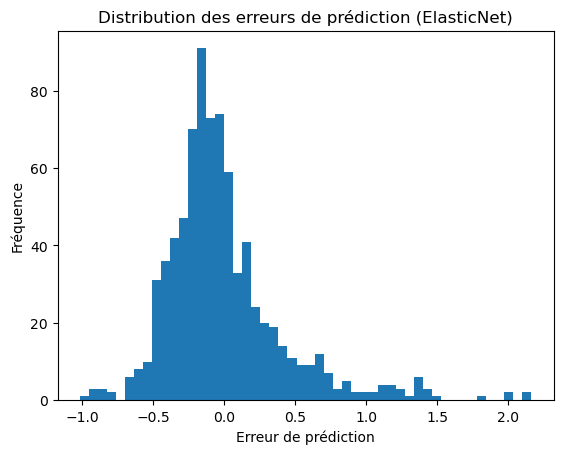

In [403]:
plt.hist(errors, bins=50)
plt.xlabel('Erreur de prédiction')
plt.ylabel('Fréquence')
plt.title('Distribution des erreurs de prédiction (ElasticNet)')
plt.show()

In [475]:
from sklearn.linear_model import LassoCV

In [495]:
lasso_model = LassoCV(eps=0.1,n_alphas=100,cv=5)

In [497]:
lasso_model.fit(X_train,y_train)

LassoCV(cv=5, eps=0.1)

In [499]:
lasso_model.alpha_

6203.587441386862

In [501]:
test_prediction=lasso_model.predict(X_test)

In [503]:
RMSE = np.sqrt(mean_squared_error(y_test,test_prediction))
RMSE

93972.39661135056

In [505]:
MAE = mean_absolute_error(y_test,test_prediction)
MAE

71858.48979071276

In [509]:
lasso_model.coef_

array([ 46447.89640887,  13174.94584387,   3042.20440965,      0.        ,
         -613.00363761,      0.        ,   6235.64700678,      0.        ,
            0.        , -11149.30612452,   5869.70828342,   1393.91043963,
         -315.00426644,   6660.13217924,  -9096.29266193,  -7413.76962198,
        -6150.6296293 ,   3043.30521847,  -3656.67835162,  -8380.12663872,
            0.        ,      0.        ,     -0.        ,    687.60240922,
        -5413.66238185,   3900.45228378,     -0.        ,     -0.        ,
        -5907.4999322 ,  -4556.99310821,     -0.        ,      0.        ,
           -0.        ,   7646.13928764,     -0.        ,  -4894.37540124,
        -1556.66494497,  -6765.38524986,      0.        ,     -0.        ,
            0.        ,     -0.        ,      0.        ,  10182.52152567,
        -6129.2529361 ,    724.058178  ,     -0.        ,   -483.42362525,
         -113.91157571,   -384.21754541,      0.        ,  -2077.12359306,
            0.        ,  

## Model Random Forest

In [405]:
from sklearn.ensemble import RandomForestRegressor

In [407]:
rf = RandomForestRegressor(random_state=42)

In [409]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [411]:
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

In [413]:
grid_search_rf.fit(X_train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 500]},
             verbose=2)

In [415]:
best_rf = grid_search_rf.best_estimator_

In [417]:
rf_predictions = best_rf.predict(X_test)

In [419]:
rmse_rf = np.sqrt(mean_squared_error(y_test, rf_predictions))
rmse_rf

0.4121176052735623

In [421]:
mae_rf = mean_absolute_error(y_test, rf_predictions)
mae_rf

0.2792012220853446

## Logarythmique distribution